In [ ]:
#**********************************************#
# Visualization of the first stage network     #
#   results.                                   #
#**********************************************#

In [12]:
import gen1_pipeline as pipe
from blocks import SG_Dataset
import construct_alph as alph
import pickle as pkl

# pipeline = pipe.Gen1_Pipeline.load_from_checkpoint('./gen1_log/gen1_save-80ep.ckpt').cuda().eval()
with open('./gen1_log/gen1_pipe.pkl', 'rb') as f:
    pipeline = pkl.load(f).cuda().eval()
train_set = SG_Dataset(pipe.valid_path)

In [13]:
dump_result = False

In [21]:
import pickle as pkl
import torch
import cosma_algebra as ca

# %matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

train_set.set_crop(64)
print(f"Len: {len(train_set)}")

ls = torch.nn.L1Loss().cuda()

Setting crop 64...
Len: 77419


In [15]:
# We've tried to do energy optimization, but it hasn't pay out

# from openmm.app import *
# from openmm import *
# from openmm.unit import *

# import fg_preproc as fg
# import subprocess as sub

In [16]:
def predict_draw(i):
    with torch.no_grad():
        cosma, amino = train_set[i].values()
        cosma_tens = torch.tensor(np.array([cosma]), device='cuda')
        amino_tens = torch.tensor(np.array([amino]), device='cuda')
        result_tens = pipeline(amino_tens)

        # loss = ls(result_tens, encoded_tens).detach().cpu().numpy()
        sloss = pipeline.loss(result_tens, cosma_tens).detach().cpu().numpy()

        result = result_tens.detach().cpu().numpy()[0]

        pmtrx = ca.get_lmtrx_from_cosma_E(result[0])
        pmtrx = ca.normalize(pmtrx)

        rcosma = ca.cosma_from_pmtrx(pmtrx, pmtrx)
        rcosma_tens = torch.tensor(np.array([[rcosma]]), device='cuda')
        rloss = pipeline.loss(rcosma_tens, cosma_tens).detach().cpu().numpy()

        loss = ls(cosma_tens, rcosma_tens).detach().cpu().numpy()
    
    # loaded = train_set.load_item(i)

    pmtrx0 = ca.normalize(ca.get_lmtrx_from_cosma_E(cosma[0]))
    coord1 = ca.centralize(ca.coord_from_pmtrx(pmtrx0 * 3.8))
    # coord2 = ca.centralize(ca.coord_from_pmtrx(pmtrx))
    # coord2 = ca.orthogonalize(ca.get_tmtrx(coord1) @ coord2.T) @ coord2
    coord2 = ca.align_lmtrx_to_coord(pmtrx * 3.8, coord1)
    rmsd = ca.get_rmsd(coord1, coord2) #* np.mean(ca.length(loaded['coord']))

    coord3 = None

    item = train_set.load_item(i)
    amino_list = item['amino']
    id = item['id']
    crop = item['crop']

    if dump_result and crop < 256:
        
        out1 = alph.dump_struct(alph.construct_pdb_from_alpha_mono(id, coord2, amino_list))
        print(f"First output: {out1}\n\n\n")
        raise "OpenMM unsupported here..."
        # out2 = out1[:-3] + 'rebuilt.pdb'
        # try:
        #     verbose = sub.run(f"pulchra304/bin/pulchra -p -v {out1}", shell=True, capture_output=True)
        #     print(verbose.stdout.decode("utf-8"))
        #     print('\n\n\n')
        #     pdb = PDBFile(out2)
        #     print(f"Second output: {out2}")

        #     forcefield = ForceField('amber14/protein.ff14SB.xml', 'amber14/tip3pfb.xml')
        #     modeller = Modeller(pdb.topology, pdb.positions)
        #     modeller.addHydrogens(forcefield)
        #     modeller.addSolvent(forcefield, model='tip3p', padding=1*nanometer)
        #     system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME,
        #                                      nonbondedCutoff=1*nanometer, constraints=HBonds)
        #     integrator = VerletIntegrator(0.001*picoseconds)
        #     simulation = Simulation(modeller.topology, system, integrator)
        #     simulation.context.setPositions(modeller.positions)
        #     simulation.minimizeEnergy()
        #     simulation.step(25000)         # 10000
        #     print('DONE\n\n\n')
        #     positions = simulation.context.getState(getPositions=True).getPositions()
        #     modeller = Modeller(modeller.topology, positions)
        #     modeller.deleteWater()

        #     out3 = f"prot_out/openmm_{id}.pdb"
        #     with open(out3, 'wt') as f:
        #         PDBFile.writeFile(modeller.topology, modeller.positions, f)
        #     print(f"Third output: {out3}")

        #     coord3 = fg.fg_read_pdb(id, out3)[0]['coord']
        #     coord3 = ca.align_lmtrx_to_coord(ca.diff(coord3), coord1, expected_det=1)

        #     print(f"RMSD (OpenMM): {ca.get_rmsd(coord1, coord3)}\n\n\n")
        # except Exception as e:
        #     print(e)
    
    else:
        print('Skipping energy optimization...')

    print(f"{i}:\tL1 = {loss}\n\tSSIM = {sloss} [raw]\n\tSSIM = {rloss} [ref]\n\tRMSD = {rmsd} A*")

    plt.figure(dpi=200)
    plt.subplot(2, 4, 1).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(cosma[0], cmap='gray')

    plt.subplot(2, 4, 2).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(rcosma, cmap='gray')
    plt.subplot(2, 4, 3).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(np.abs(rcosma - cosma[0]))


    plt.subplot(2, 4, 4).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(ca.cosma_from_coords(coord1, coord2), cmap='gray')
    # plt.imshow(result[0], cmap='gray')
    # plt.show()

    plt.subplot(2, 4, 5).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(ca.get_dst(coord1, coord1), cmap='gray')
    plt.subplot(2, 4, 6).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(ca.get_dst(coord2, coord2), cmap='gray')
    err = np.abs(ca.get_dst(coord1, coord1) - ca.get_dst(coord2, coord2))
    # print(np.sqrt(np.mean(err ** 2)))
    plt.subplot(2, 4, 7).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(err)
    plt.show()

    plt.figure(dpi=150)
    ax = plt.axes(projection = '3d')
    # fig = plt.figure(dpi=150)
    # ax = fig.add_subplot(1, 2, 1, projection = '3d')
    # ax.set_box_aspect((1, 1, 1))
    prot1, prot2 = coord1, coord2
    ax.scatter(prot1[0, :], prot1[1, :], prot1[2, :], color = 'red', s = 5) #to make two plots...
    ax.plot(prot1[0, :], prot1[1, :], prot1[2, :], color = 'red', linewidth = 0.5)

    # ax = fig.add_subplot(1, 2, 2, projection = '3d')
    # ax.set_box_aspect((1, 1, 1))
    ax.scatter(prot2[0, :], prot2[1, :], prot2[2, :], color = 'blue', s = 5)
    ax.plot(prot2[0, :], prot2[1, :], prot2[2, :], color = 'blue', linewidth = 0.5)

    if coord3 is not None:
        prot1 = coord3
        ax.scatter(prot1[0, :], prot1[1, :], prot1[2, :], color = 'purple', s = 5)
        ax.plot(prot1[0, :], prot1[1, :], prot1[2, :], color = 'purple', linewidth = 0.5)

    plt.show()

Skipping energy optimization...
19490:	L1 = 0.1408708393573761
	SSIM = 0.02562612295150757 [raw]
	SSIM = 0.019559025764465332 [ref]
	RMSD = 2.0439543806342026 A*


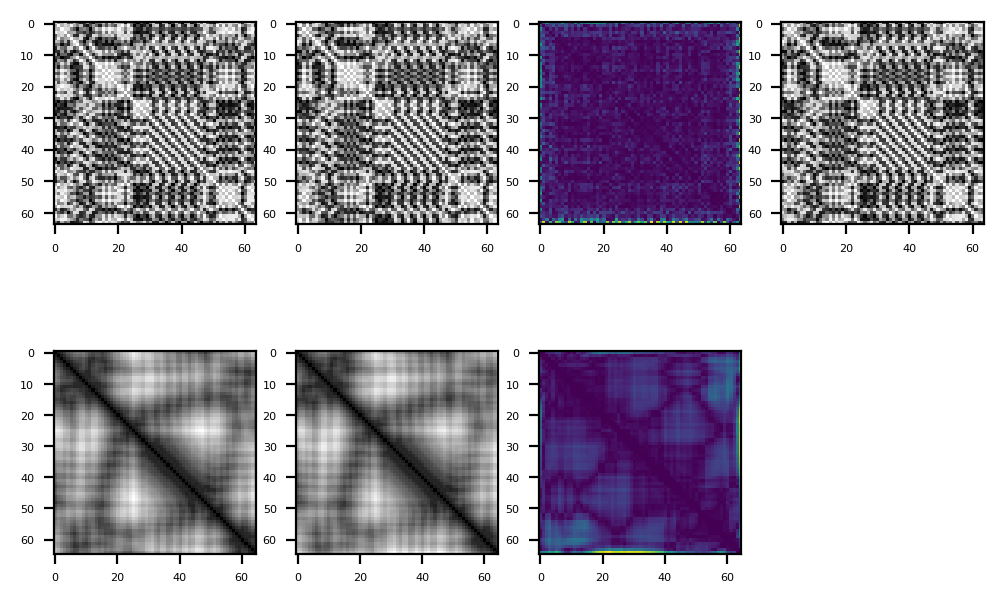

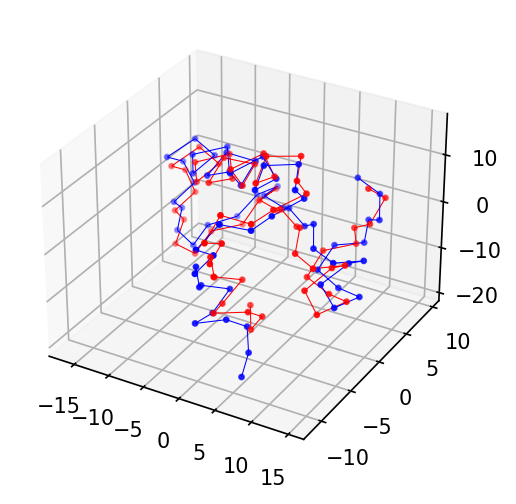

In [25]:
plt.close('all')
i = np.random.choice(len(train_set))
predict_draw(i)

Testing random amino sequences

In [26]:
def random_prot(n):
    amino = ca.rand_prot_gen(n)

    with torch.no_grad():
        amino_tens = torch.tensor(np.array([ca.amino_list_to_array_stack(amino, False)]).astype(np.float32), device='cuda')
        result_tens = pipeline(amino_tens)
        result = result_tens.detach().cpu().numpy()[0]

    pmtrx = ca.get_lmtrx_from_cosma_E(result[0])
    pmtrx = ca.normalize(pmtrx)
    coord = ca.centralize(ca.coord_from_pmtrx(pmtrx * 3.8))

    print(amino)

    plt.figure(dpi=100)
    plt.subplot(1, 2, 1)
    plt.imshow(result[0], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(ca.cosma_from_pmtrx(pmtrx, pmtrx), cmap='gray')
    plt.show()

    plt.figure(dpi=150)
    ax = plt.axes(projection = '3d')
    # ax.set_box_aspect((1, 1, 1))
    ax.scatter(coord[0, :], coord[1, :], coord[2, :], color = 'blue', s = 5)
    ax.plot(coord[0, :], coord[1, :], coord[2, :], color = 'blue', linewidth = 0.5)
    plt.show()

['LEU', 'ASN', 'PHE', 'LYS', 'HIS', 'MET', 'ALA', 'ARG', 'GLU', 'MET', 'GLU', 'ALA', 'SER', 'THR', 'ASP', 'ALA', 'ARG', 'LYS', 'ILE', 'TYR', 'LEU', 'HIS', 'PHE', 'LEU', 'GLY', 'GLN', 'GLU', 'THR', 'THR', 'GLY', 'LYS', 'ARG', 'ALA', 'ARG', 'LYS', 'SER', 'LYS', 'GLY', 'MET', 'GLN', 'GLY', 'ASP', 'TYR', 'ARG', 'LEU', 'HIS', 'ILE', 'GLU', 'ASN', 'ASN', 'PHE', 'VAL', 'GLY', 'ALA', 'LEU', 'SER', 'GLU', 'HIS', 'PHE', 'LEU', 'SER', 'LEU', 'ALA', 'SER', 'ASN', 'PRO', 'ASN', 'PRO', 'CYS', 'SER', 'ASP', 'ASN', 'VAL', 'ILE', 'SER', 'SER', 'ALA', 'PHE', 'VAL', 'ASP', 'GLU', 'LEU', 'CYS', 'PHE', 'ALA', 'GLU', 'ALA', 'LYS', 'LEU', 'VAL', 'SER', 'GLU', 'VAL', 'ILE', 'ARG', 'LYS']


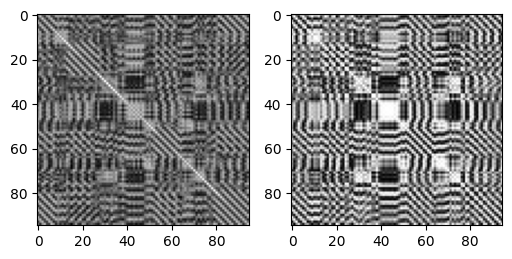

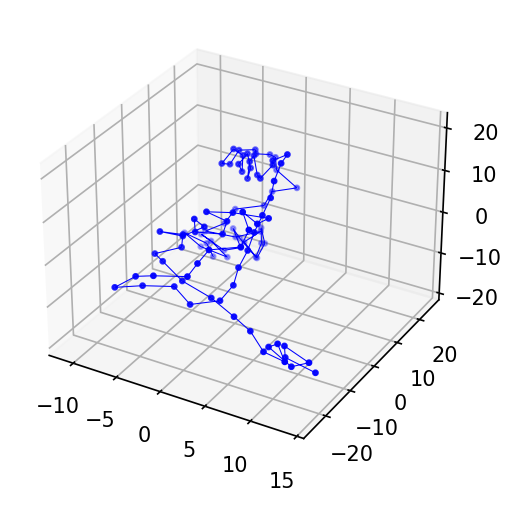

In [27]:
# plt.close('all')
random_prot(96)